## CAMELS-GB streamflow daily data pre-processing

#### The main objective of this script is to perform a pre-processing analysis of the available streamflow data from the Camels-GB, having a close look at their gaps.

Written by: Thiago Victor Medeiros do Nascimento

References:

1. CAMELS-GB: https://catalogue.ceh.ac.uk/documents/8344e4f3-d2ea-44f5-8afa-86d2987543a9
2. Paper: https://essd.copernicus.org/articles/12/2459/2020/

First we import some useful modules:

In [2]:
import geopandas as gpd                                      # Pandas for geospatial analysis
from shapely.geometry import Point, Polygon                  # Module used for geospatial analysis     
import pymannkendall as mk                                   # Module used for trend-computation
from plotly.offline import plot
import contextily as cx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import warnings                                              
import datetime                                              # Datetime module pretty useful for time-series analysis
import tqdm as tqdm                                          # Useful module to access the progress bar of a loop
import os
import glob
warnings.simplefilter(action='ignore', category=Warning)     # Module useful for taking out some unecessary warnings

%config Completer.use_jedi = False                           # This improve the auto-fill function

import geospatialfunctions as geospatialfunctions            # Geospatialfunctions is a module with useful functions

First we should set our directory:

In [3]:
path = r"C:\Users\nascimth\Documents\Thiago\Eawag\Python\Datasets"
os.chdir(path)
os.getcwd()

'C:\\Users\\nascimth\\Documents\\Thiago\\Eawag\\Python\\Datasets'

Here we can import the full GRDC network information:

In [8]:
network = pd.read_csv(r'GB\stations\CAMELS_GB_topographic_attributes.csv', skiprows=0, encoding='latin-1', sep= ",")
network = network.set_index("gauge_id")

network

gauge_name  gauge_lat  gauge_lon  gauge_easting  \
gauge_id                                                                  
10002            Ugie at Inverugie      57.53      -1.83         410113   
10003               Ythan at Ellon      57.36      -2.09         394684   
1001               Wick at Tarroul      58.48      -3.27         326202   
101002             Medina at Shide      50.69      -1.29         450359   
101005    Eastern Yar at Budbridge      50.65      -1.25         453120   
...                            ...        ...        ...            ...   
95001       Inver at Little Assynt      58.17      -5.15         214693   
96001       Halladale at Halladale      58.48      -3.90         289125   
96002             Naver at Apigill      58.48      -4.21         271363   
96004       Strathmore at Allnabad      58.35      -4.64         245314   
97002            Thurso at Halkirk      58.52      -3.49         313123   

          gauge_northing  gauge_elev    area  dpsbar  elev_mean  elev_min  \
gauge_id                                                                    
10002             848516         8.5  325.72    42.3       87.0       9.5   
10003             830370         3.8  532.29    55.1      108.0       3.5   
1001              954915        13.0  158.18    29.9       80.0      12.9   
101002             88113        10.4   30.61    80.0       60.0       9.4   
101005             83520        17.2   24.31    87.0       92.0      17.2   
...                  ...         ...     ...     ...        ...       ...   
95001             924921        60.3  138.47   190.3      292.0      63.1   
96001             956081        23.2  193.72    55.1      175.0      22.9   
96002             956765         5.1  474.01   111.7      224.0       7.7   
96004             942895        21.9  105.36   192.3      325.0      25.3   
97002             959561        30.2  414.48    37.6      149.0      30.2   

          elev_10  elev_50  elev_90  elev_max  
gauge_id                                       
10002        38.6     84.1    140.1     233.7  
10003        54.1    106.1    160.8     380.4  
1001         30.6     78.8    135.2     241.4  
101002       26.8     56.8     98.0     193.2  
101005       32.9     84.0    157.2     234.6  
...           ...      ...      ...       ...  
95001        79.8    269.7    541.6    1108.6  
96001       110.5    167.4    254.1     568.7  
96002        97.7    187.7    402.9     959.0  
96004       150.0    306.9    535.3     851.4  
97002        69.9    142.3    225.8     434.8  

[671 rows x 14 columns]

Another factor to be considered is the exclusion of gauges which have the influence of resevoirs. 

In [11]:
reservoirs_infos = pd.read_csv(r'GB\stations\CAMELS_GB_humaninfluence_attributes.csv', skiprows=0, encoding='latin-1', sep= ",")
reservoirs_infos = reservoirs_infos.set_index("gauge_id")

reservoirs_infos

benchmark_catch  surfacewater_abs  groundwater_abs  discharges  \
gauge_id                                                                  
10002                  N               NaN              NaN         NaN   
10003                  N               NaN              NaN         NaN   
1001                   N               NaN              NaN         NaN   
101002                 N             0.006            0.023       0.018   
101005                 N             0.001            0.015       0.053   
...                  ...               ...              ...         ...   
95001                  Y               NaN              NaN         NaN   
96001                  N               NaN              NaN         NaN   
96002                  Y               NaN              NaN         NaN   
96004                  N               NaN              NaN         NaN   
97002                  N               NaN              NaN         NaN   

          abs_agriculture_perc  abs_amenities_perc  abs_energy_perc  \
gauge_id                                                              
10002                      NaN                 NaN              NaN   
10003                      NaN                 NaN              NaN   
1001                       NaN                 NaN              NaN   
101002                   18.92                 0.0              0.0   
101005                   11.27                 0.0              0.0   
...                        ...                 ...              ...   
95001                      NaN                 NaN              NaN   
96001                      NaN                 NaN              NaN   
96002                      NaN                 NaN              NaN   
96004                      NaN                 NaN              NaN   
97002                      NaN                 NaN              NaN   

          abs_environmental_perc  abs_industry_perc  abs_watersupply_perc  \
gauge_id                                                                    
10002                        NaN                NaN                   NaN   
10003                        NaN                NaN                   NaN   
1001                         NaN                NaN                   NaN   
101002                       0.0              18.29                 62.79   
101005                       0.0               0.22                 88.51   
...                          ...                ...                   ...   
95001                        NaN                NaN                   NaN   
96001                        NaN                NaN                   NaN   
96002                        NaN                NaN                   NaN   
96004                        NaN                NaN                   NaN   
97002                        NaN                NaN                   NaN   

          ...  reservoir_cap  reservoir_he  reservoir_nav  reservoir_drain  \
gauge_id  ...                                                                
10002     ...              0           NaN            NaN              NaN   
10003     ...              0           NaN            NaN              NaN   
1001      ...          11500           0.0            0.0              0.0   
101002    ...              0           NaN            NaN              NaN   
101005    ...              0           NaN            NaN              NaN   
...       ...            ...           ...            ...              ...   
95001     ...              0           NaN            NaN              NaN   
96001     ...              0           NaN            NaN              NaN   
96002     ...              0           NaN            NaN              NaN   
96004     ...              0           NaN            NaN              NaN   
97002     ...          18116           0.0            0.0              0.0   

          reservoir_wr  reservoir_fs  reservoir_env  reservoir_nousedata  \
gauge_id        

Another factor to be considered is the date when the station was closed (if it was). We should filter for stations with data available at least after 2010:

In [12]:
dataclosure_infos = pd.read_csv(r'GB\stations\CAMELS_GB_hydrometry_attributes.csv', skiprows=0, encoding='latin-1', sep= ",")
dataclosure_infos = dataclosure_infos.set_index("gauge_id")

dataclosure_infos

station_type flow_period_start flow_period_end  flow_perc_complete  \
gauge_id                                                                      
10002              VA        1971-02-01      2015-09-30               99.25   
10003              VA        1983-05-19      2015-09-30               71.93   
1001               VA        1995-11-09      2015-09-30               44.21   
101002             US        1970-10-01      2015-09-30               96.78   
101005             FV        1982-04-14      2015-09-30               74.22   
...               ...               ...             ...                 ...   
95001              VA        1977-08-01      2015-09-30               84.81   
96001              VA        1976-01-01      2015-09-30               88.33   
96002              VA        1977-06-10      2015-09-30               85.13   
96004              VA        1987-12-01      2015-09-30               61.85   
97002              VA        1972-01-01      2015-09-30               97.22   

          bankfull_flow  structurefull_flow  q5_uncert_upper  q5_uncert_lower  \
gauge_id                                                                        
10002             100.0                 NaN              NaN              NaN   
10003              80.0                 NaN              NaN              NaN   
1001               31.2                 NaN            25.34           -25.94   
101002             17.8                 7.3              NaN              NaN   
101005              NaN                 NaN              NaN              NaN   
...                 ...                 ...              ...              ...   
95001              40.5                 NaN            14.44           -14.76   
96001             100.5                 NaN            35.71           -35.32   
96002              30.1                 NaN            47.33           -46.09   
96004             112.4                 NaN              NaN              NaN   
97002             164.1                 NaN              NaN              NaN   

          q25_uncert_upper  q25_uncert_lower  q50_uncert_upper  \
gauge_id                                                         
10002                11.95            -12.37              9.55   
10003                12.58            -12.46              8.73   
1001                 17.71            -17.01              9.00   
101002               30.46            -29.56             21.90   
101005               19.15            -18.38             22.99   
...                    ...               ...               ...   
95001                11.84            -11.76             13.05   
96001                19.58            -19.44             13.96   
96002                31.27            -31.11             14.22   
96004                  NaN               NaN               NaN   
97002                  NaN               NaN               NaN   

          q50_uncert_lower  q75_uncert_upper  q75_uncert_lower  \
gauge_id                                                         
10002                -9.40              9.35             -9.61   
10003                -8.68             11.69            -11.89   
1001                 -9.56              8.84             -8.68   
101002              -21.28             14.25            -14.71   
101005              -24.29             14.74            -14.94   
...                    ...               ...               ...   
95001               -13.14             10.69            -11.08   
96001               -14.11             11.85            -12.28   
96002               -14.13             11.72            -11.61   
96004                  NaN               NaN               NaN   
97002                  NaN               NaN               NaN   

          q95_uncert_upper  q95_uncert_lower  q99_uncert_upper  \
gauge_id                                                         
10002                 9.02             -9.23              8.25   
10003      

Therefore here we can save our final dataframe with all the needed information:

In [19]:
network["num_reservoir"] = reservoirs_infos["num_reservoir"]
network["flow_period_start"] = pd.to_datetime(dataclosure_infos["flow_period_start"], format='%Y-%m-%d')
network["flow_period_end"] = pd.to_datetime(dataclosure_infos["flow_period_end"], format='%Y-%m-%d')

network

gauge_name  gauge_lat  gauge_lon  gauge_easting  \
gauge_id                                                                  
10002            Ugie at Inverugie      57.53      -1.83         410113   
10003               Ythan at Ellon      57.36      -2.09         394684   
1001               Wick at Tarroul      58.48      -3.27         326202   
101002             Medina at Shide      50.69      -1.29         450359   
101005    Eastern Yar at Budbridge      50.65      -1.25         453120   
...                            ...        ...        ...            ...   
95001       Inver at Little Assynt      58.17      -5.15         214693   
96001       Halladale at Halladale      58.48      -3.90         289125   
96002             Naver at Apigill      58.48      -4.21         271363   
96004       Strathmore at Allnabad      58.35      -4.64         245314   
97002            Thurso at Halkirk      58.52      -3.49         313123   

          gauge_northing  gauge_elev    area  dpsbar  elev_mean  elev_min  \
gauge_id                                                                    
10002             848516         8.5  325.72    42.3       87.0       9.5   
10003             830370         3.8  532.29    55.1      108.0       3.5   
1001              954915        13.0  158.18    29.9       80.0      12.9   
101002             88113        10.4   30.61    80.0       60.0       9.4   
101005             83520        17.2   24.31    87.0       92.0      17.2   
...                  ...         ...     ...     ...        ...       ...   
95001             924921        60.3  138.47   190.3      292.0      63.1   
96001             956081        23.2  193.72    55.1      175.0      22.9   
96002             956765         5.1  474.01   111.7      224.0       7.7   
96004             942895        21.9  105.36   192.3      325.0      25.3   
97002             959561        30.2  414.48    37.6      149.0      30.2   

          elev_10  elev_50  elev_90  elev_max  num_reservoir  \
gauge_id                                                       
10002        38.6     84.1    140.1     233.7              0   
10003        54.1    106.1    160.8     380.4              0   
1001         30.6     78.8    135.2     241.4              1   
101002       26.8     56.8     98.0     193.2              0   
101005       32.9     84.0    157.2     234.6              0   
...           ...      ...      ...       ...            ...   
95001        79.8    269.7    541.6    1108.6              0   
96001       110.5    167.4    254.1     568.7              0   
96002        97.7    187.7    402.9     959.0              0   
96004       150.0    306.9    535.3     851.4              0   
97002        69.9    142.3    225.8     434.8              2   

         flow_period_start flow_period_end  
gauge_id                                    
10002           1971-02-01      2015-09-30  
10003           1983-05-19      2015-09-30  
1001            1995-11-09      2015-09-30  
101002          1970-10-01      2015-09-30  
101005          1982-04-14      2015-09-30  
...                    ...             ...  
95001           1977-08-01      2015-09-30  
96001           1976-01-01      2015-09-30  
96002           1977-06-10      2015-09-30  
96004           1987-12-01      2015-09-30  
97002           1972-01-01      2015-09-30  

[671 rows x 17 columns]

Here we select only gauges without the influence of reservoirs (num_reservoir = 0):

In [30]:
network_2 = network[network.num_reservoir < 1]
network_2

gauge_name  gauge_lat  gauge_lon  gauge_easting  \
gauge_id                                                                  
10002            Ugie at Inverugie      57.53      -1.83         410113   
10003               Ythan at Ellon      57.36      -2.09         394684   
101002             Medina at Shide      50.69      -1.29         450359   
101005    Eastern Yar at Budbridge      50.65      -1.25         453120   
102001          Cefni at Bodffordd      53.27      -4.36         242925   
...                            ...        ...        ...            ...   
93001          Carron at New Kelso      57.43      -5.43         194186   
95001       Inver at Little Assynt      58.17      -5.15         214693   
96001       Halladale at Halladale      58.48      -3.90         289125   
96002             Naver at Apigill      58.48      -4.21         271363   
96004       Strathmore at Allnabad      58.35      -4.64         245314   

          gauge_northing  gauge_elev    area  dpsbar  elev_mean  elev_min  \
gauge_id                                                                    
10002             848516         8.5  325.72    42.3       87.0       9.5   
10003             830370         3.8  532.29    55.1      108.0       3.5   
101002             88113        10.4   30.61    80.0       60.0       9.4   
101005             83520        17.2   24.31    87.0       92.0      17.2   
102001            376857        34.2   21.01    29.0       68.0      33.5   
...                  ...         ...     ...     ...        ...       ...   
93001             842885         5.6  139.21   291.6      356.0       6.8   
95001             924921        60.3  138.47   190.3      292.0      63.1   
96001             956081        23.2  193.72    55.1      175.0      22.9   
96002             956765         5.1  474.01   111.7      224.0       7.7   
96004             942895        21.9  105.36   192.3      325.0      25.3   

          elev_10  elev_50  elev_90  elev_max  num_reservoir  \
gauge_id                                                       
10002        38.6     84.1    140.1     233.7              0   
10003        54.1    106.1    160.8     380.4              0   
101002       26.8     56.8     98.0     193.2              0   
101005       32.9     84.0    157.2     234.6              0   
102001       55.2     67.8     82.2     104.4              0   
...           ...      ...      ...       ...            ...   
93001        86.7    344.4    645.3    1052.7              0   
95001        79.8    269.7    541.6    1108.6              0   
96001       110.5    167.4    254.1     568.7              0   
96002        97.7    187.7    402.9     959.0              0   
96004       150.0    306.9    535.3     851.4              0   

         flow_period_start flow_period_end  
gauge_id                                    
10002           1971-02-01      2015-09-30  
10003           1983-05-19      2015-09-30  
101002          1970-10-01      2015-09-30  
101005          1982-04-14      2015-09-30  
102001          1988-10-10      2015-09-30  
...                    ...             ...  
93001           1979-01-01      2015-09-30  
95001           1977-08-01      2015-09-30  
96001           1976-01-01      2015-09-30  
96002           1977-06-10      2015-09-30  
96004           1987-12-01      2015-09-30  

[505 rows x 17 columns]

<AxesSubplot:xlabel='gauge_id'>

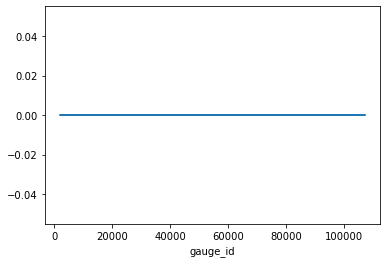

In [31]:
network_2.num_reservoir.plot()

This leave us with 505 gauges

In [33]:
network_3 = network_2[network_2.flow_period_start <= "1990"]
network_3

gauge_name  gauge_lat  gauge_lon  gauge_easting  \
gauge_id                                                                  
10002            Ugie at Inverugie      57.53      -1.83         410113   
10003               Ythan at Ellon      57.36      -2.09         394684   
101002             Medina at Shide      50.69      -1.29         450359   
101005    Eastern Yar at Budbridge      50.65      -1.25         453120   
102001          Cefni at Bodffordd      53.27      -4.36         242925   
...                            ...        ...        ...            ...   
93001          Carron at New Kelso      57.43      -5.43         194186   
95001       Inver at Little Assynt      58.17      -5.15         214693   
96001       Halladale at Halladale      58.48      -3.90         289125   
96002             Naver at Apigill      58.48      -4.21         271363   
96004       Strathmore at Allnabad      58.35      -4.64         245314   

          gauge_northing  gauge_elev    area  dpsbar  elev_mean  elev_min  \
gauge_id                                                                    
10002             848516         8.5  325.72    42.3       87.0       9.5   
10003             830370         3.8  532.29    55.1      108.0       3.5   
101002             88113        10.4   30.61    80.0       60.0       9.4   
101005             83520        17.2   24.31    87.0       92.0      17.2   
102001            376857        34.2   21.01    29.0       68.0      33.5   
...                  ...         ...     ...     ...        ...       ...   
93001             842885         5.6  139.21   291.6      356.0       6.8   
95001             924921        60.3  138.47   190.3      292.0      63.1   
96001             956081        23.2  193.72    55.1      175.0      22.9   
96002             956765         5.1  474.01   111.7      224.0       7.7   
96004             942895        21.9  105.36   192.3      325.0      25.3   

          elev_10  elev_50  elev_90  elev_max  num_reservoir  \
gauge_id                                                       
10002        38.6     84.1    140.1     233.7              0   
10003        54.1    106.1    160.8     380.4              0   
101002       26.8     56.8     98.0     193.2              0   
101005       32.9     84.0    157.2     234.6              0   
102001       55.2     67.8     82.2     104.4              0   
...           ...      ...      ...       ...            ...   
93001        86.7    344.4    645.3    1052.7              0   
95001        79.8    269.7    541.6    1108.6              0   
96001       110.5    167.4    254.1     568.7              0   
96002        97.7    187.7    402.9     959.0              0   
96004       150.0    306.9    535.3     851.4              0   

         flow_period_start flow_period_end  
gauge_id                                    
10002           1971-02-01      2015-09-30  
10003           1983-05-19      2015-09-30  
101002          1970-10-01      2015-09-30  
101005          1982-04-14      2015-09-30  
102001          1988-10-10      2015-09-30  
...                    ...             ...  
93001           1979-01-01      2015-09-30  
95001           1977-08-01      2015-09-30  
96001           1976-01-01      2015-09-30  
96002           1977-06-10      2015-09-30  
96004           1987-12-01      2015-09-30  

[480 rows x 17 columns]

In [36]:
network_4 = network_3[network_3.flow_period_end >= "2014"]
network_4

gauge_name  gauge_lat  gauge_lon  gauge_easting  \
gauge_id                                                                  
10002            Ugie at Inverugie      57.53      -1.83         410113   
10003               Ythan at Ellon      57.36      -2.09         394684   
101002             Medina at Shide      50.69      -1.29         450359   
101005    Eastern Yar at Budbridge      50.65      -1.25         453120   
102001          Cefni at Bodffordd      53.27      -4.36         242925   
...                            ...        ...        ...            ...   
93001          Carron at New Kelso      57.43      -5.43         194186   
95001       Inver at Little Assynt      58.17      -5.15         214693   
96001       Halladale at Halladale      58.48      -3.90         289125   
96002             Naver at Apigill      58.48      -4.21         271363   
96004       Strathmore at Allnabad      58.35      -4.64         245314   

          gauge_northing  gauge_elev    area  dpsbar  elev_mean  elev_min  \
gauge_id                                                                    
10002             848516         8.5  325.72    42.3       87.0       9.5   
10003             830370         3.8  532.29    55.1      108.0       3.5   
101002             88113        10.4   30.61    80.0       60.0       9.4   
101005             83520        17.2   24.31    87.0       92.0      17.2   
102001            376857        34.2   21.01    29.0       68.0      33.5   
...                  ...         ...     ...     ...        ...       ...   
93001             842885         5.6  139.21   291.6      356.0       6.8   
95001             924921        60.3  138.47   190.3      292.0      63.1   
96001             956081        23.2  193.72    55.1      175.0      22.9   
96002             956765         5.1  474.01   111.7      224.0       7.7   
96004             942895        21.9  105.36   192.3      325.0      25.3   

          elev_10  elev_50  elev_90  elev_max  num_reservoir  \
gauge_id                                                       
10002        38.6     84.1    140.1     233.7              0   
10003        54.1    106.1    160.8     380.4              0   
101002       26.8     56.8     98.0     193.2              0   
101005       32.9     84.0    157.2     234.6              0   
102001       55.2     67.8     82.2     104.4              0   
...           ...      ...      ...       ...            ...   
93001        86.7    344.4    645.3    1052.7              0   
95001        79.8    269.7    541.6    1108.6              0   
96001       110.5    167.4    254.1     568.7              0   
96002        97.7    187.7    402.9     959.0              0   
96004       150.0    306.9    535.3     851.4              0   

         flow_period_start flow_period_end  
gauge_id                                    
10002           1971-02-01      2015-09-30  
10003           1983-05-19      2015-09-30  
101002          1970-10-01      2015-09-30  
101005          1982-04-14      2015-09-30  
102001          1988-10-10      2015-09-30  
...                    ...             ...  
93001           1979-01-01      2015-09-30  
95001           1977-08-01      2015-09-30  
96001           1976-01-01      2015-09-30  
96002           1977-06-10      2015-09-30  
96004           1987-12-01      2015-09-30  

[475 rows x 17 columns]

Quick check of the columns' types:

In [37]:
network_4.dtypes

gauge_name                   object
gauge_lat                   float64
gauge_lon                   float64
gauge_easting                 int64
gauge_northing                int64
gauge_elev                  float64
area                        float64
dpsbar                      float64
elev_mean                   float64
elev_min                    float64
elev_10                     float64
elev_50                     float64
elev_90                     float64
elev_max                    float64
num_reservoir                 int64
flow_period_start    datetime64[ns]
flow_period_end      datetime64[ns]
dtype: object

In [38]:
network_streams = network_4

Here we can plot our dataset using one of the geospatialfunctions function:

(<Figure size 1080x2160 with 1 Axes>, <AxesSubplot:>)

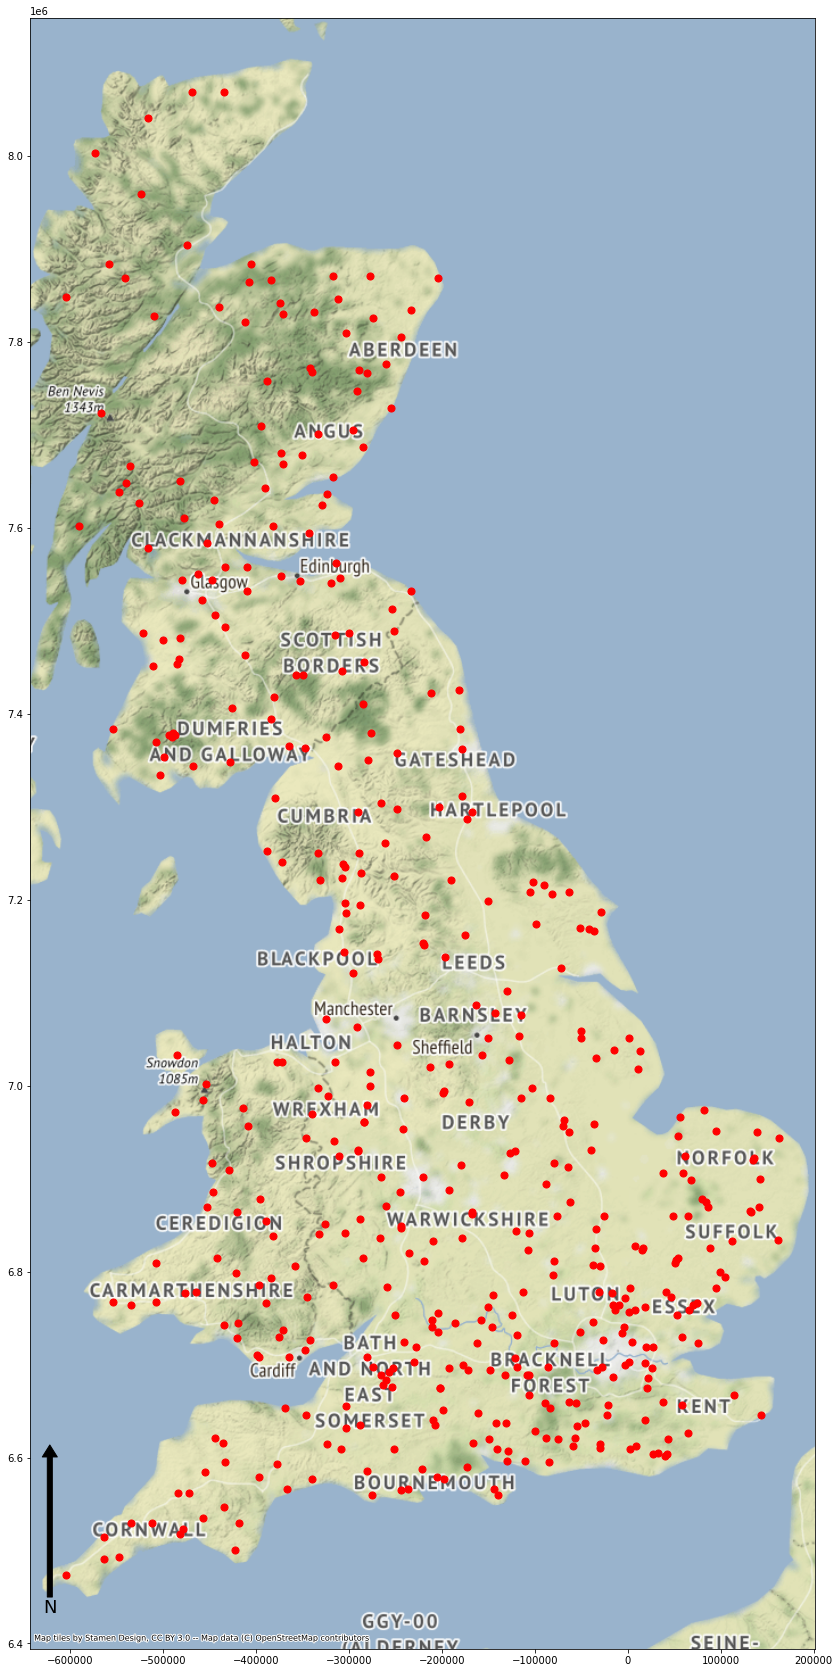

In [39]:
coords = network_streams[["gauge_lon", "gauge_lat"]]
coords.astype(float)

geospatialfunctions.plotpointsmap(coords, markersize_map = 50, colorpoints = 'red')

1. Now we can read our individual time-series and organize our dataset in a single dataframe:

#### Full time-series organization:

At this part we can organize the time-series in a single dataframe where each column will represent a different station, and each row a different date.

In [40]:
# First we can check our files within the folder:
path =r'GB\original'
filenames = glob.glob(path + "/*.csv")
len(filenames)

671

Here we can use a for loop to retrieve each station, organize which information is needed, an concatenate everything together:

In [49]:
i = 0
timeseriesfinal = pd.DataFrame(index = pd.date_range('10-01-1970','09-30-2015', freq='D'))

#### The tqdm module is useful for checking the progress bar of the loop.
for filename in tqdm.tqdm(filenames):
    # First we read our time-series:
    data = pd.read_csv(filename, encoding='latin-1', engine='python', skiprows = 0, delimiter = ",", usecols = [0, 4, 5])

    # We define new column names:
    names = ['dates', 'Qmmday', "Qm3s"]
    data.columns = names

    # Convert our column of dates to datetime format:
    data["dates"] = pd.to_datetime(data["dates"], format='%Y-%m-%d')

    # Here we can set the index as the dates column:
    data.set_index("dates", inplace = True)

    # First we can retrieve the station name:
    namestation = os.path.basename(filename)
    namestation = namestation.split("_", 5)[4]
    timeseriesfinal.loc[:, int(namestation)] = data.Qm3s

100%|████████████████████████████████████████████████████████████████████████████████| 671/671 [00:59<00:00, 11.20it/s]


In [50]:
timeseriesfinal

10002   10003   1001    101002  101005  102001  106001  107001  \
1970-10-01     NaN     NaN     NaN    0.15     NaN     NaN     NaN     NaN   
1970-10-02     NaN     NaN     NaN    0.14     NaN     NaN     NaN     NaN   
1970-10-03     NaN     NaN     NaN    0.14     NaN     NaN     NaN     NaN   
1970-10-04     NaN     NaN     NaN    0.14     NaN     NaN     NaN     NaN   
1970-10-05     NaN     NaN     NaN    0.15     NaN     NaN     NaN     NaN   
...            ...     ...     ...     ...     ...     ...     ...     ...   
2015-09-26    2.47    3.52    0.40    0.27    0.15    0.02    1.25    0.20   
2015-09-27    2.26    3.40    0.36    0.25    0.14    0.02    1.04    0.17   
2015-09-28    2.12    3.33    0.33    0.24    0.13    0.02    0.84    0.14   
2015-09-29    2.02    3.26    0.31    0.24    0.12    0.02    0.62    0.13   
2015-09-30    1.94    3.20    0.29    0.23    0.12    0.02    0.49    0.12   

            11001   11003   ...  9004    9005    92001   93001   94001   \
1970-10-01   11.31     NaN  ...     NaN    0.83     NaN     NaN     NaN   
1970-10-02   11.54     NaN  ...     NaN    2.20     NaN     NaN     NaN   
1970-10-03   11.54     NaN  ...     NaN    1.34     NaN     NaN     NaN   
1970-10-04   13.20     NaN  ...     NaN    1.81     NaN     NaN     NaN   
1970-10-05   14.53     NaN  ...     NaN    1.26     NaN     NaN     NaN   
...            ...     ...  ...     ...     ...     ...     ...     ...   
2015-09-26    9.13    5.04  ...    1.19    0.60   10.47    5.96   18.06   
2015-09-27    8.62    4.77  ...    1.15    0.55    9.47    3.15   17.13   
2015-09-28    8.24    4.59  ...    1.13    0.51    8.49    2.18   16.06   
2015-09-29    7.99    4.42  ...    1.10    0.49    7.42    1.69   14.40   
2015-09-30    7.73    4.32  ...    1.09    0.47    6.58    1.47   13.09   

            95001   96001   96002   96004   97002   
1970-10-01     NaN     NaN     NaN     NaN     NaN  
1970-10-02     NaN     NaN     NaN     NaN     NaN  
1970-10-03     NaN     NaN     NaN     NaN     NaN  
1970-10-04     NaN     NaN     NaN     NaN     NaN  
1970-10-05     NaN     NaN     NaN     NaN     NaN  
...            ...     ...     ...     ...     ...  
2015-09-26    5.44    1.72    3.48    2.26    2.67  
2015-09-27    4.82    1.18    3.20    1.14    2.52  
2015-09-28    4.50    0.90    2.93    0.76    2.40  
2015-09-29    4.27    0.75    2.70    0.58    2.51  
2015-09-30    4.08    0.65    2.45    0.47    2.65  

[16436 rows x 671 columns]

In [51]:
# Here we can filter only data which are associated to streams (no lakes)
timeseriesfinalstreams = timeseriesfinal.loc[:, network_4.index.tolist()]
timeseriesfinalstreams

10002   10003   101002  101005  102001  11001   11003   11004   \
1970-10-01     NaN     NaN    0.15     NaN     NaN   11.31     NaN     NaN   
1970-10-02     NaN     NaN    0.14     NaN     NaN   11.54     NaN     NaN   
1970-10-03     NaN     NaN    0.14     NaN     NaN   11.54     NaN     NaN   
1970-10-04     NaN     NaN    0.14     NaN     NaN   13.20     NaN     NaN   
1970-10-05     NaN     NaN    0.15     NaN     NaN   14.53     NaN     NaN   
...            ...     ...     ...     ...     ...     ...     ...     ...   
2015-09-26    2.47    3.52    0.27    0.15    0.02    9.13    5.04    1.30   
2015-09-27    2.26    3.40    0.25    0.14    0.02    8.62    4.77    1.27   
2015-09-28    2.12    3.33    0.24    0.13    0.02    8.24    4.59    1.23   
2015-09-29    2.02    3.26    0.24    0.12    0.02    7.99    4.42    1.20   
2015-09-30    1.94    3.20    0.23    0.12    0.02    7.73    4.32    1.18   

            12001   12002   ...  90003   9002    9003    9004    9005    \
1970-10-01   26.08     NaN  ...     NaN    6.53    1.20     NaN    0.83   
1970-10-02   45.36     NaN  ...     NaN    8.49    1.29     NaN    2.20   
1970-10-03   35.03     NaN  ...     NaN    8.49    1.38     NaN    1.34   
1970-10-04   52.63     NaN  ...     NaN   12.25    1.90     NaN    1.81   
1970-10-05   44.08     NaN  ...     NaN   10.98    1.52     NaN    1.26   
...            ...     ...  ...     ...     ...     ...     ...     ...   
2015-09-26   14.95   19.72  ...    1.90    6.54    1.21    1.19    0.60   
2015-09-27   13.64   18.08  ...    1.27    5.93    1.07    1.15    0.55   
2015-09-28   12.75   16.91  ...    1.01    5.63    0.98    1.13    0.51   
2015-09-29   12.11   16.08  ...    0.85    5.36    0.91    1.10    0.49   
2015-09-30   11.54   15.22  ...    0.75    5.12    0.85    1.09    0.47   

            93001   95001   96001   96002   96004   
1970-10-01     NaN     NaN     NaN     NaN     NaN  
1970-10-02     NaN     NaN     NaN     NaN     NaN  
1970-10-03     NaN     NaN     NaN     NaN     NaN  
1970-10-04     NaN     NaN     NaN     NaN     NaN  
1970-10-05     NaN     NaN     NaN     NaN     NaN  
...            ...     ...     ...     ...     ...  
2015-09-26    5.96    5.44    1.72    3.48    2.26  
2015-09-27    3.15    4.82    1.18    3.20    1.14  
2015-09-28    2.18    4.50    0.90    2.93    0.76  
2015-09-29    1.69    4.27    0.75    2.70    0.58  
2015-09-30    1.47    4.08    0.65    2.45    0.47  

[16436 rows x 475 columns]

In [52]:
# Finally we can save our dataset:
timeseriesfinalstreams.to_csv(r'GB\timeseries\timeseries_camelsGB.csv') 
network_streams.to_csv(r'GB\timeseries\network_camelsGB.csv') 

#### Here we read our previously saved datasets:

2. Finally we can check the gaps and data availability in our final dataframe:

In [53]:
# First the network information:
network_streams = pd.read_csv(r'GB\timeseries\network_camelsGB.csv', encoding='latin-1', engine='python', delimiter = ",",
                             index_col = 0)
network_streams

gauge_name  gauge_lat  gauge_lon  gauge_easting  \
gauge_id                                                                  
10002            Ugie at Inverugie      57.53      -1.83         410113   
10003               Ythan at Ellon      57.36      -2.09         394684   
101002             Medina at Shide      50.69      -1.29         450359   
101005    Eastern Yar at Budbridge      50.65      -1.25         453120   
102001          Cefni at Bodffordd      53.27      -4.36         242925   
...                            ...        ...        ...            ...   
93001          Carron at New Kelso      57.43      -5.43         194186   
95001       Inver at Little Assynt      58.17      -5.15         214693   
96001       Halladale at Halladale      58.48      -3.90         289125   
96002             Naver at Apigill      58.48      -4.21         271363   
96004       Strathmore at Allnabad      58.35      -4.64         245314   

          gauge_northing  gauge_elev    area  dpsbar  elev_mean  elev_min  \
gauge_id                                                                    
10002             848516         8.5  325.72    42.3       87.0       9.5   
10003             830370         3.8  532.29    55.1      108.0       3.5   
101002             88113        10.4   30.61    80.0       60.0       9.4   
101005             83520        17.2   24.31    87.0       92.0      17.2   
102001            376857        34.2   21.01    29.0       68.0      33.5   
...                  ...         ...     ...     ...        ...       ...   
93001             842885         5.6  139.21   291.6      356.0       6.8   
95001             924921        60.3  138.47   190.3      292.0      63.1   
96001             956081        23.2  193.72    55.1      175.0      22.9   
96002             956765         5.1  474.01   111.7      224.0       7.7   
96004             942895        21.9  105.36   192.3      325.0      25.3   

          elev_10  elev_50  elev_90  elev_max  num_reservoir  \
gauge_id                                                       
10002        38.6     84.1    140.1     233.7              0   
10003        54.1    106.1    160.8     380.4              0   
101002       26.8     56.8     98.0     193.2              0   
101005       32.9     84.0    157.2     234.6              0   
102001       55.2     67.8     82.2     104.4              0   
...           ...      ...      ...       ...            ...   
93001        86.7    344.4    645.3    1052.7              0   
95001        79.8    269.7    541.6    1108.6              0   
96001       110.5    167.4    254.1     568.7              0   
96002        97.7    187.7    402.9     959.0              0   
96004       150.0    306.9    535.3     851.4              0   

         flow_period_start flow_period_end  
gauge_id                                    
10002           1971-02-01      2015-09-30  
10003           1983-05-19      2015-09-30  
101002          1970-10-01      2015-09-30  
101005          1982-04-14      2015-09-30  
102001          1988-10-10      2015-09-30  
...                    ...             ...  
93001           1979-01-01      2015-09-30  
95001           1977-08-01      2015-09-30  
96001           1976-01-01      2015-09-30  
96002           1977-06-10      2015-09-30  
96004           1987-12-01      2015-09-30  

[475 rows x 17 columns]

In [54]:
# Then we read our data:
timeseriesfinal = pd.read_csv(r'GB\timeseries\timeseries_camelsGB.csv', encoding='latin-1', engine='python', delimiter = ",",
                             index_col = 0)

timeseriesfinal

10002  10003  101002  101005  102001  11001  11003  11004  12001  \
1970-10-01    NaN    NaN    0.15     NaN     NaN  11.31    NaN    NaN  26.08   
1970-10-02    NaN    NaN    0.14     NaN     NaN  11.54    NaN    NaN  45.36   
1970-10-03    NaN    NaN    0.14     NaN     NaN  11.54    NaN    NaN  35.03   
1970-10-04    NaN    NaN    0.14     NaN     NaN  13.20    NaN    NaN  52.63   
1970-10-05    NaN    NaN    0.15     NaN     NaN  14.53    NaN    NaN  44.08   
...           ...    ...     ...     ...     ...    ...    ...    ...    ...   
2015-09-26   2.47   3.52    0.27    0.15    0.02   9.13   5.04   1.30  14.95   
2015-09-27   2.26   3.40    0.25    0.14    0.02   8.62   4.77   1.27  13.64   
2015-09-28   2.12   3.33    0.24    0.13    0.02   8.24   4.59   1.23  12.75   
2015-09-29   2.02   3.26    0.24    0.12    0.02   7.99   4.42   1.20  12.11   
2015-09-30   1.94   3.20    0.23    0.12    0.02   7.73   4.32   1.18  11.54   

            12002  ...  90003   9002  9003  9004  9005  93001  95001  96001  \
1970-10-01    NaN  ...    NaN   6.53  1.20   NaN  0.83    NaN    NaN    NaN   
1970-10-02    NaN  ...    NaN   8.49  1.29   NaN  2.20    NaN    NaN    NaN   
1970-10-03    NaN  ...    NaN   8.49  1.38   NaN  1.34    NaN    NaN    NaN   
1970-10-04    NaN  ...    NaN  12.25  1.90   NaN  1.81    NaN    NaN    NaN   
1970-10-05    NaN  ...    NaN  10.98  1.52   NaN  1.26    NaN    NaN    NaN   
...           ...  ...    ...    ...   ...   ...   ...    ...    ...    ...   
2015-09-26  19.72  ...   1.90   6.54  1.21  1.19  0.60   5.96   5.44   1.72   
2015-09-27  18.08  ...   1.27   5.93  1.07  1.15  0.55   3.15   4.82   1.18   
2015-09-28  16.91  ...   1.01   5.63  0.98  1.13  0.51   2.18   4.50   0.90   
2015-09-29  16.08  ...   0.85   5.36  0.91  1.10  0.49   1.69   4.27   0.75   
2015-09-30  15.22  ...   0.75   5.12  0.85  1.09  0.47   1.47   4.08   0.65   

            96002  96004  
1970-10-01    NaN    NaN  
1970-10-02    NaN    NaN  
1970-10-03    NaN    NaN  
1970-10-04    NaN    NaN  
1970-10-05    NaN    NaN  
...           ...    ...  
2015-09-26   3.48   2.26  
2015-09-27   3.20   1.14  
2015-09-28   2.93   0.76  
2015-09-29   2.70   0.58  
2015-09-30   2.45   0.47  

[16436 rows x 475 columns]

Now we start to apply our datagaps functions:

First we aply our function for computing the gaps:

In [56]:
coords = network_streams[["gauge_lon", "gauge_lat"]]


# Our columns should be from the same type as our indexes: 
timeseriesfinal.columns = timeseriesfinal.columns.map(int)
summarygapsstations = geospatialfunctions.summarygaps(timeseriesfinal, coords)

summarygapsstations["area"] = network_streams.area

summarygapsstations

CoordX  CoordY  NumGaps  PercentageGaps    area
Code                                                   
10002    -1.83   57.53    123.0        0.748357  325.72
10003    -2.09   57.36   4613.0       28.066440  532.29
101002   -1.29   50.69    530.0        3.224629   30.61
101005   -1.25   50.65   4237.0       25.778778   24.31
102001   -4.36   53.27   6595.0       40.125335   21.01
...        ...     ...      ...             ...     ...
93001    -5.43   57.43   3014.0       18.337795  139.21
95001    -5.15   58.17   2496.0       15.186177  138.47
96001    -3.90   58.48   1918.0       11.669506  193.72
96002    -4.21   58.48   2444.0       14.869798  474.01
96004    -4.64   58.35   6270.0       38.147968  105.36

[475 rows x 5 columns]

Now we can plot the gaps:

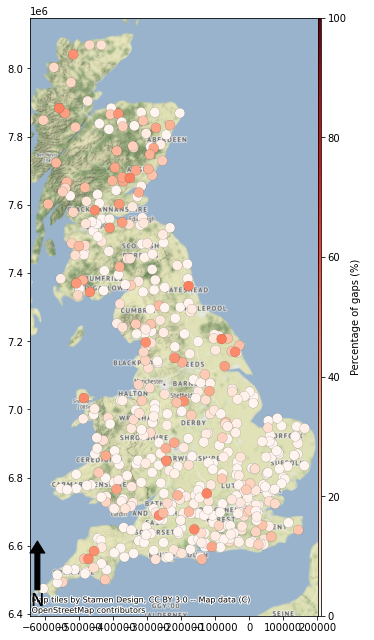

In [57]:
figplot, axesplot = geospatialfunctions.plotgapsmap(summarygapsstations = summarygapsstations, crsproj = 'epsg:4326', backmapproj = True, 
                                       figsizeproj = (18, 11), cmapproj = "Reds", legend_title = "Percentage of gaps (%)",
                                       legend_orientation = "vertical", pad_map = 0, markersize_map = 100,
                                       north_arrow = True, 
                                       set_map_limits = False, minx = -25, miny = 35, maxx = 30, maxy = 72)

First we can define a gap threshould and check our dataset:

In [67]:
summarygapsstations[summarygapsstations.PercentageGaps < 2.0]

CoordX  CoordY  NumGaps  PercentageGaps     area  \
Code                                                      
10002   -1.83   57.53    123.0        0.748357   325.72   
11001   -2.19   57.22      0.0        0.000000  1269.14   
12001   -2.60   57.05      0.0        0.000000  1380.06   
14001   -2.95   56.33      0.0        0.000000   308.74   
15013   -3.51   56.42     21.0        0.127768   173.28   
...       ...     ...      ...             ...      ...   
84016   -4.02   55.93      0.0        0.000000    35.34   
84020   -4.15   55.96    224.0        1.362862    51.92   
85003   -4.72   56.34     97.0        0.590168    79.92   
9002    -2.49   57.54      0.0        0.000000   961.45   
9005    -3.03   57.35      0.0        0.000000    68.08   

                        geometry  
Code                              
10002  POINT (-1.83000 57.53000)  
11001  POINT (-2.19000 57.22000)  
12001  POINT (-2.60000 57.05000)  
14001  POINT (-2.95000 56.33000)  
15013  POINT (-3.51000 56.42000)  
...                          ...  
84016  POINT (-4.02000 55.93000)  
84020  POINT (-4.15000 55.96000)  
85003  POINT (-4.72000 56.34000)  
9002   POINT (-2.49000 57.54000)  
9005   POINT (-3.03000 57.35000)  

[220 rows x 6 columns]

<AxesSubplot:xlabel='Code'>

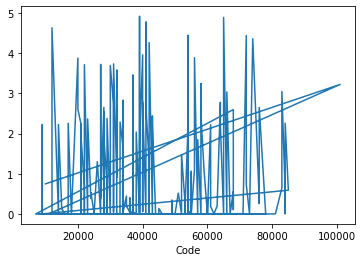

In [61]:
summarygapsstations[summarygapsstations.PercentageGaps < 5.0].PercentageGaps.plot()

Now we can plot the gauges below a gap threshould:

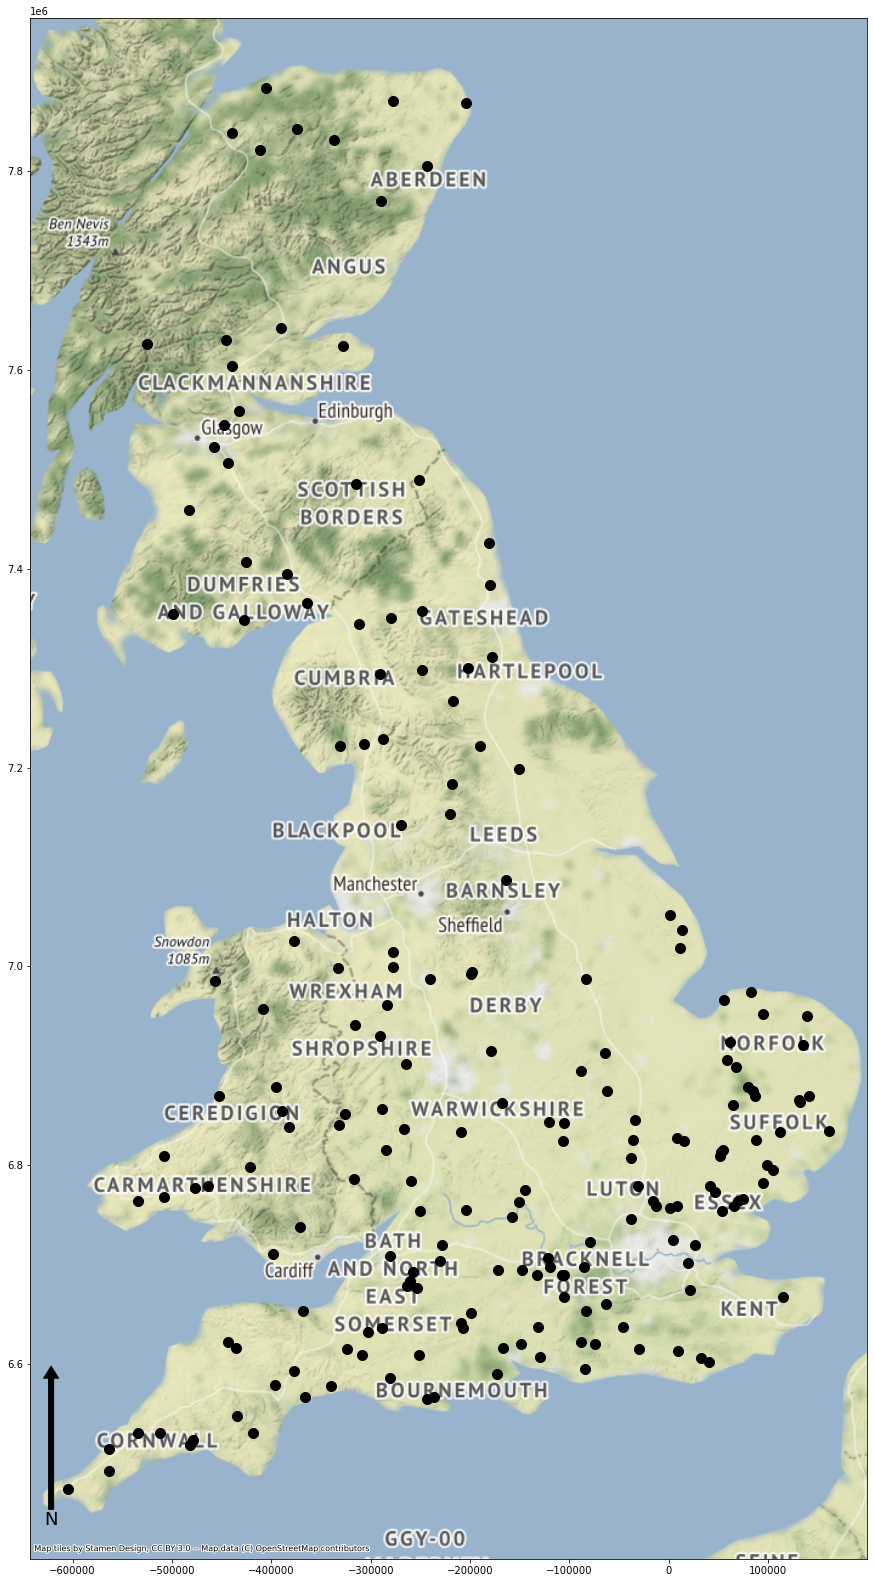

In [73]:
figplot, axesplot = geospatialfunctions.plotpointsmap(summarygapsstations[summarygapsstations.PercentageGaps < 1.0], showcodes = False,  
                                  backmapproj = True,
                                  markersize_map = 100, 
                                  north_arrow = True, 
                                  set_map_limits = True,
                                  minx = -25, miny = 35, maxx = 30, maxy = 72)

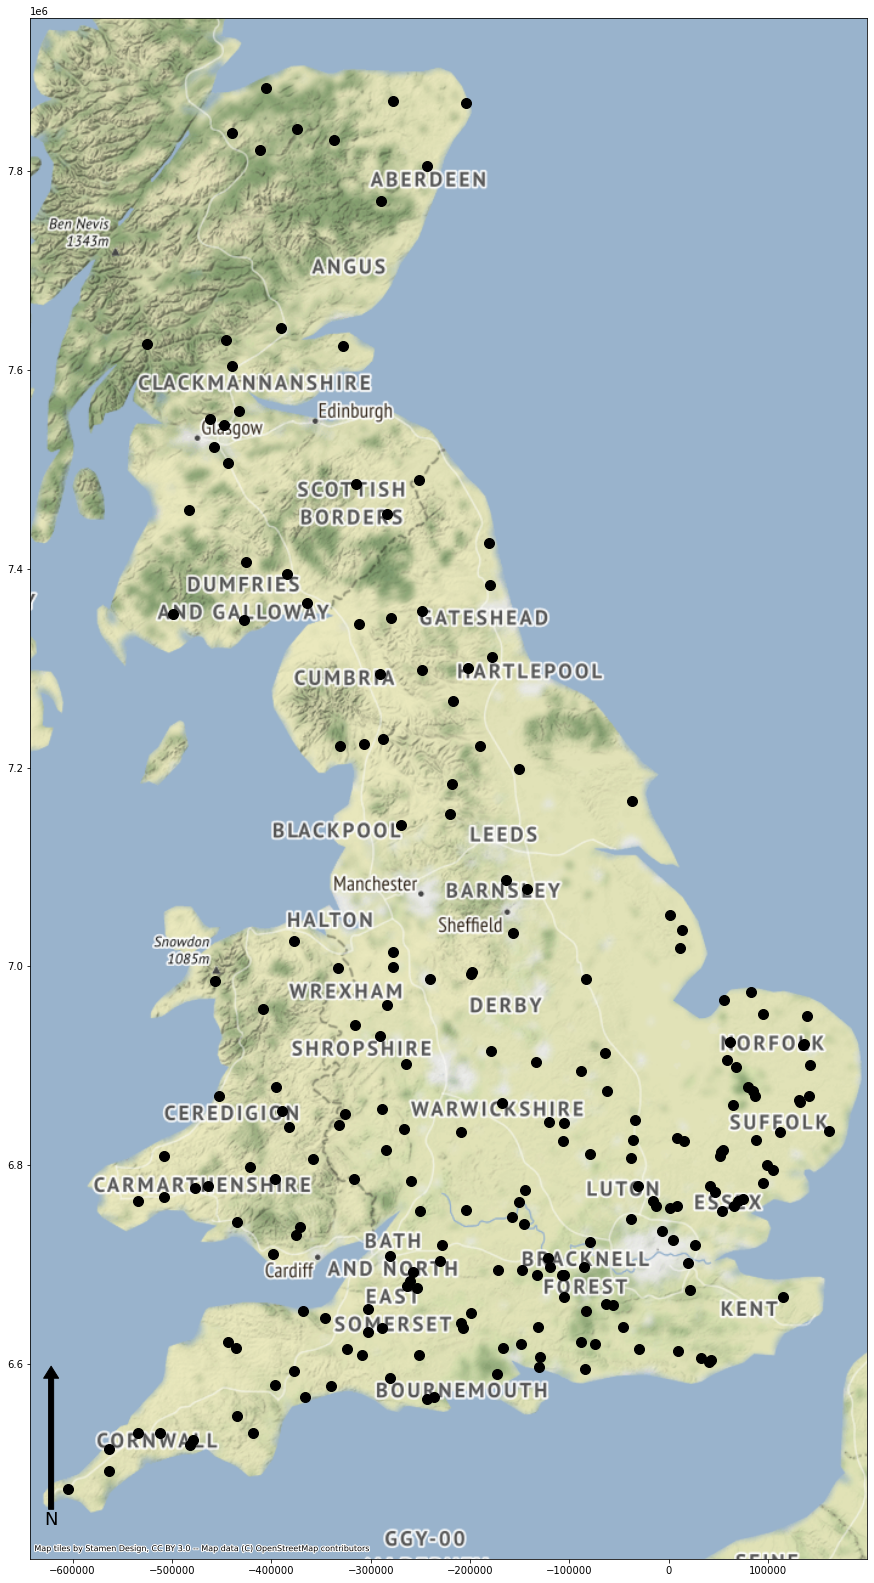

In [72]:
figplot, axesplot = geospatialfunctions.plotpointsmap(summarygapsstations[summarygapsstations.PercentageGaps < 2.0], showcodes = False,  
                                  backmapproj = True,
                                  markersize_map = 100, 
                                  north_arrow = True, 
                                  set_map_limits = True,
                                  minx = -25, miny = 35, maxx = 30, maxy = 72)

<AxesSubplot:>

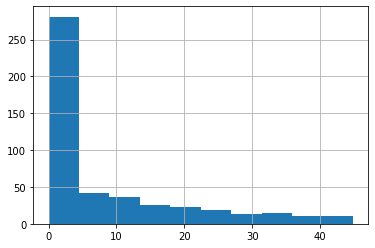

In [63]:
summarygapsstations.PercentageGaps.hist()

{'whiskers': [<matplotlib.lines.Line2D at 0x2298f7b8fa0>,
 'caps': [<matplotlib.lines.Line2D at 0x2298f7b8100>,
 'boxes': [<matplotlib.lines.Line2D at 0x2298f7b96f0>],
 'medians': [<matplotlib.lines.Line2D at 0x2298f7bab60>],
 'fliers': [<matplotlib.lines.Line2D at 0x2298f7bae30>],
 'means': []}

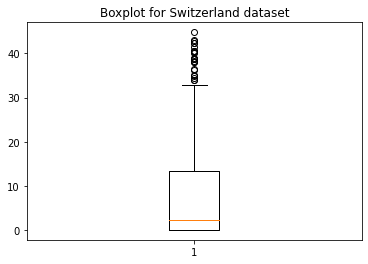

In [68]:
fig1, ax1 = plt.subplots()
ax1.set_title('Boxplot for Switzerland dataset')
ax1.boxplot(summarygapsstations.loc[:, "PercentageGaps"])

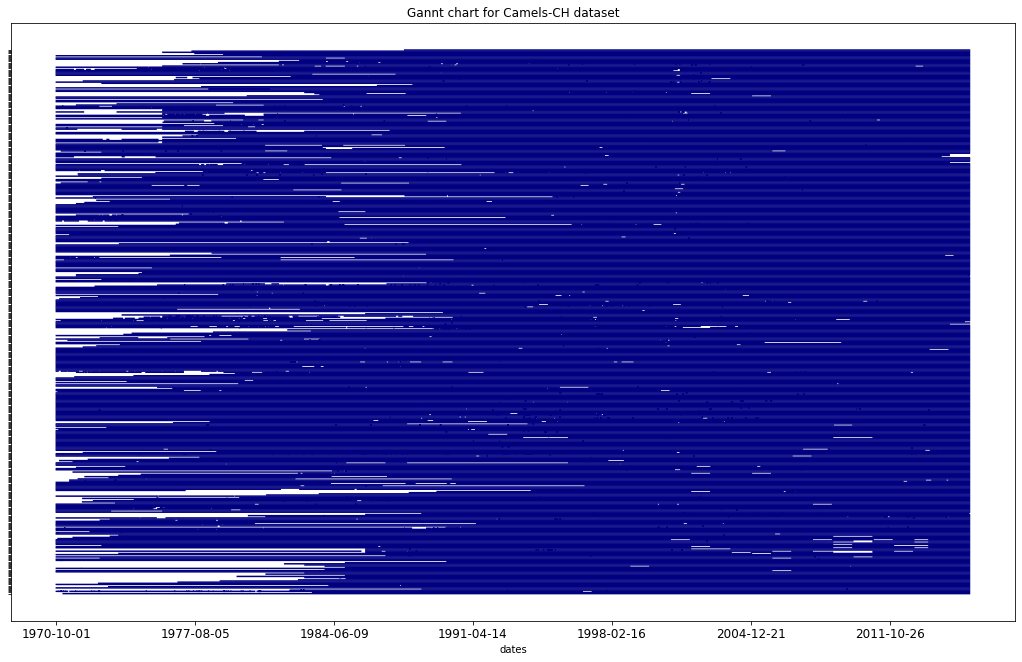

In [69]:
figplot, axesplot = geospatialfunctions.plotganntchart(timeseriesfinal_gantt = timeseriesfinal, figsize_chart = (18, 11), 
                                   showcodes = False,
                                   color_chart = "navy", fontsize_chart = 12,facecolor_chart = "white", 
                                   title_chart = "Gannt chart for Camels-CH dataset")

Here we can plot the gannt only for the stations with a threshould of gaps:

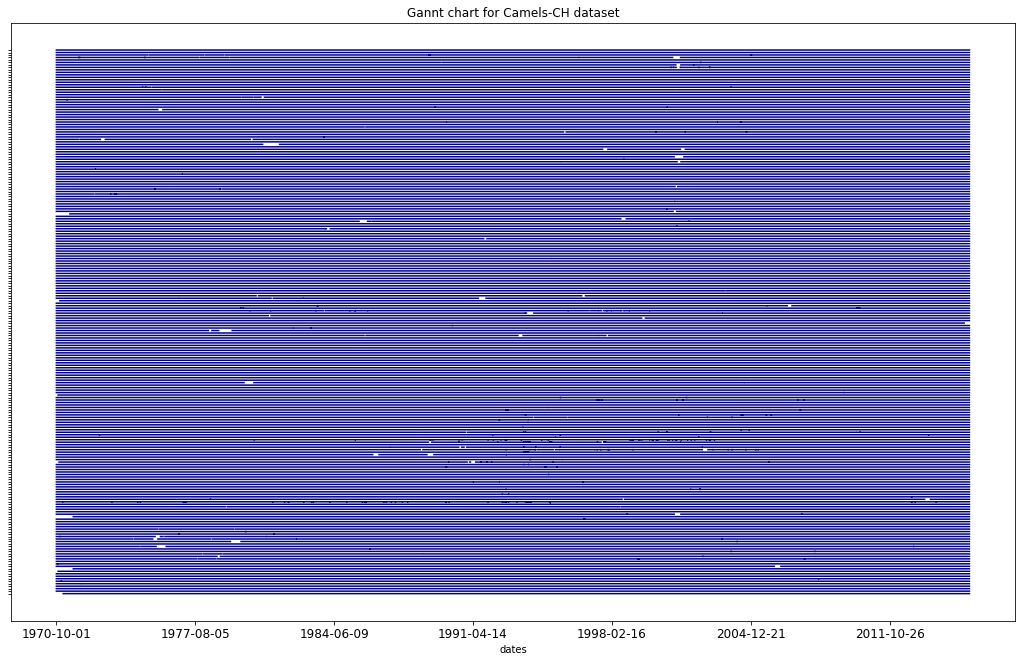

In [70]:
figplot, axesplot = geospatialfunctions.plotganntchart(timeseriesfinal_gantt = timeseriesfinal.loc[:, summarygapsstations[summarygapsstations.PercentageGaps < 2.0].index.tolist()], 
                                                       
                                                       figsize_chart = (18, 11), showcodes = False,
                                                       color_chart = "navy", fontsize_chart = 12,facecolor_chart = "white", 
                                                       title_chart = "Gannt chart for Camels-CH dataset")

Here we can check for only Switzerland:

In [74]:
summarygapsstationsless2 = summarygapsstations[summarygapsstations.PercentageGaps < 2.0]
summarygapsstationsless2

CoordX  CoordY  NumGaps  PercentageGaps     area  \
Code                                                      
10002   -1.83   57.53    123.0        0.748357   325.72   
11001   -2.19   57.22      0.0        0.000000  1269.14   
12001   -2.60   57.05      0.0        0.000000  1380.06   
14001   -2.95   56.33      0.0        0.000000   308.74   
15013   -3.51   56.42     21.0        0.127768   173.28   
...       ...     ...      ...             ...      ...   
84016   -4.02   55.93      0.0        0.000000    35.34   
84020   -4.15   55.96    224.0        1.362862    51.92   
85003   -4.72   56.34     97.0        0.590168    79.92   
9002    -2.49   57.54      0.0        0.000000   961.45   
9005    -3.03   57.35      0.0        0.000000    68.08   

                        geometry  
Code                              
10002  POINT (-1.83000 57.53000)  
11001  POINT (-2.19000 57.22000)  
12001  POINT (-2.60000 57.05000)  
14001  POINT (-2.95000 56.33000)  
15013  POINT (-3.51000 56.42000)  
...                          ...  
84016  POINT (-4.02000 55.93000)  
84020  POINT (-4.15000 55.96000)  
85003  POINT (-4.72000 56.34000)  
9002   POINT (-2.49000 57.54000)  
9005   POINT (-3.03000 57.35000)  

[220 rows x 6 columns]

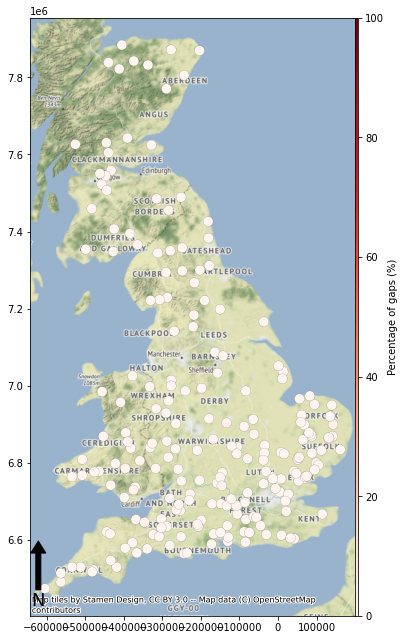

In [75]:
figplot, axesplot = geospatialfunctions.plotgapsmap(summarygapsstations = summarygapsstationsless2, crsproj = 'epsg:4326', backmapproj = True, 
                                       figsizeproj = (18, 11), cmapproj = "Reds", legend_title = "Percentage of gaps (%)",
                                       legend_orientation = "vertical", pad_map = 0, markersize_map = 100,
                                       north_arrow = True, 
                                       set_map_limits = False, minx = -25, miny = 35, maxx = 30, maxy = 72)

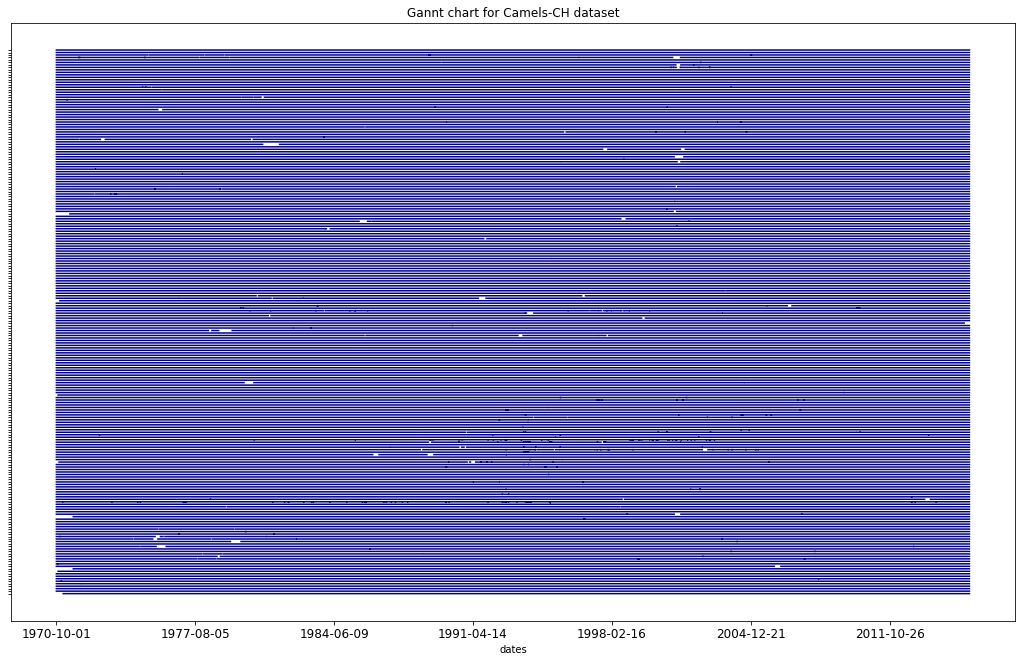

In [76]:
figplot, axesplot = geospatialfunctions.plotganntchart(timeseriesfinal_gantt = timeseriesfinal.loc[:, summarygapsstationsless2.index.tolist()], 
                                                       
                                                       figsize_chart = (18, 11), showcodes = False,
                                                       color_chart = "navy", fontsize_chart = 12,facecolor_chart = "white", 
                                                       title_chart = "Gannt chart for Camels-CH dataset")

Thus we save only the data from Switizerland and with less than 20% of failures:

In [77]:
# Here we can filter only data which are associated to streams (no lakes)
timeseriesfinal2 = timeseriesfinal.loc[:, summarygapsstationsless2.index.tolist()]
timeseriesfinal2

10002  11001  12001  14001  15013  16003  17003  18001  21013  \
dates                                                                       
1970-10-01    NaN  11.31  26.08   2.69   5.82   5.29   2.40   8.41   1.45   
1970-10-02    NaN  11.54  45.36   2.51   7.50   9.76   2.95   7.61   1.90   
1970-10-03    NaN  11.54  35.03   2.27   5.82   7.71   1.21   4.35   1.45   
1970-10-04    NaN  13.20  52.63   2.31   4.86   6.49   1.07  12.38   1.43   
1970-10-05    NaN  14.53  44.08   2.33   7.96   9.61   2.27  11.97   2.14   
...           ...    ...    ...    ...    ...    ...    ...    ...    ...   
2015-09-26   2.47   9.13  14.95   1.21   1.15   1.12   0.33   1.44   0.83   
2015-09-27   2.26   8.62  13.64   1.20   1.04   0.92   0.32   1.29   0.76   
2015-09-28   2.12   8.24  12.75   1.18   0.98   0.81   0.32   1.21   0.72   
2015-09-29   2.02   7.99  12.11   1.18   1.06   0.74   0.32   1.15   0.69   
2015-09-30   1.94   7.73  11.54   1.16   1.09   0.67   0.32   1.11   0.68   

            21023  ...  8009   81002  83003  84008  84014  84016  84020  \
dates              ...                                                    
1970-10-01    NaN  ...   3.87  58.85  33.18   5.21  40.38   3.29   6.87   
1970-10-02    NaN  ...  15.18  51.34  13.32   3.91  24.39   2.15   5.04   
1970-10-03    NaN  ...   7.82  33.56   5.97   1.45   8.11   0.99   2.23   
1970-10-04    NaN  ...  10.62  65.95  14.46   2.60  16.64   1.98   6.61   
1970-10-05    NaN  ...  13.31  40.28  11.41   5.13  28.49   2.54   5.24   
...           ...  ...    ...    ...    ...    ...    ...    ...    ...   
2015-09-26   0.03  ...   1.69   4.41   1.20   0.26   1.87   0.16   0.46   
2015-09-27   0.03  ...   1.45   3.30   0.99   0.19   1.46   0.15   0.34   
2015-09-28   0.03  ...   1.32   2.70   0.84   0.16   1.26   0.15   0.28   
2015-09-29   0.03  ...   1.25   2.35   0.67   0.14   1.12   0.14   0.25   
2015-09-30   0.03  ...   1.20   2.06   0.59   0.13   1.01   0.14   0.22   

            85003  9002   9005   
dates                            
1970-10-01  41.99   6.53   0.83  
1970-10-02  10.69   8.49   2.20  
1970-10-03   6.61   8.49   1.34  
1970-10-04  71.92  12.25   1.81  
1970-10-05  25.18  10.98   1.26  
...           ...    ...    ...  
2015-09-26   2.07   6.54   0.60  
2015-09-27   1.00   5.93   0.55  
2015-09-28   0.67   5.63   0.51  
2015-09-29   0.49   5.36   0.49  
2015-09-30   0.34   5.12   0.47  

[16436 rows x 220 columns]

In [78]:
network_streams2 = network_streams.loc[summarygapsstationsless2.index.tolist(), :]
network_streams2

gauge_name  gauge_lat  gauge_lon  \
Code                                                              
10002                   Ugie at Inverugie      57.53      -1.83   
11001                     Don at Parkhill      57.22      -2.19   
12001                      Dee at Woodend      57.05      -2.60   
14001                     Eden at Kemback      56.33      -2.95   
15013                Almond at Almondbank      56.42      -3.51   
...                                   ...        ...        ...   
84016           Luggie Water at Condorrat      55.93      -4.02   
84020  Glazert Water at Milton of Campsie      55.96      -4.15   
85003             Falloch at Glen Falloch      56.34      -4.72   
9002                   Deveron at Muiresk      57.54      -2.49   
9005              Allt Deveron at Cabrach      57.35      -3.03   

       gauge_easting  gauge_northing  gauge_elev     area  dpsbar  elev_mean  \
Code                                                                           
10002         410113          848516         8.5   325.72    42.3       87.0   
11001         388770          814190        32.4  1269.14   111.4      262.0   
12001         363482          795613        70.5  1380.06   185.7      512.0   
14001         341452          715796         6.2   308.74    72.7      109.0   
15013         306715          725811        20.4   173.28   196.9      408.0   
...              ...             ...         ...      ...     ...        ...   
84016         273917          672559        68.0    35.34    56.0      139.0   
84020         265646          676198        38.7    51.92   143.7      274.0   
85003         232106          719470         9.5    79.92   256.1      446.0   
9002          370551          849833        25.3   961.45   100.9      244.0   
9005          337839          829102       288.0    68.08   118.3      439.0   

       elev_min  elev_10  elev_50  elev_90  elev_max  num_reservoir  \
Code                                                                  
10002       9.5     38.6     84.1    140.1     233.7              0   
11001      34.7     89.6    220.4    509.0     873.9              0   
12001      71.3    193.0    509.2    817.9    1308.9              0   
14001       7.1     41.4    100.6    190.1     520.4              0   
15013      21.4    154.4    399.7    708.6     926.2              0   
...         ...      ...      ...      ...       ...            ...   
84016      68.6     89.1    139.6    191.5     224.2              0   
84020      40.6     75.7    259.8    489.0     577.4              0   
85003      15.1    199.3    447.4    703.2    1120.0              0   
9002       25.7    114.1    209.5    428.9     754.2              0   
9005      289.2    340.1    436.5    549.9     720.8              0   

      flow_period_start flow_period_end  
Code                                     
10002        1971-02-01      2015-09-30  
11001        1970-10-01      2015-09-30  
12001        1970-10-01      2015-09-30  
14001        1970-10-01      2015-09-30  
15013        1970-10-01      2015-09-30  
...                 ...             ...  
84016        1970-10-01      2015-09-30  
84020        1970-10-01      2015-09-30  
85003        1970-10-01      2015-09-30  
9002         1970-10-01      2015-09-30  
9005         1970-10-01      2015-09-30  

[220 rows x 17 columns]

In [80]:
# Finally we can save our dataset:
timeseriesfinal2.to_csv(r'GB\timeseries\timeseries_GB.csv') 
network_streams2.to_csv(r'GB\timeseries\network_GB.csv') 

#### Part 2:

At this part we can download the most recent streamflow data from the British official website and update our current data series:

First we import the data previously saved for the Camels-GB:

In [81]:
# First the network information:
network_streams = pd.read_csv(r'GB\timeseries\network_GB.csv', encoding='latin-1', engine='python', delimiter = ",",
                             index_col = 0)
network_streams

gauge_name  gauge_lat  gauge_lon  \
Code                                                              
10002                   Ugie at Inverugie      57.53      -1.83   
11001                     Don at Parkhill      57.22      -2.19   
12001                      Dee at Woodend      57.05      -2.60   
14001                     Eden at Kemback      56.33      -2.95   
15013                Almond at Almondbank      56.42      -3.51   
...                                   ...        ...        ...   
84016           Luggie Water at Condorrat      55.93      -4.02   
84020  Glazert Water at Milton of Campsie      55.96      -4.15   
85003             Falloch at Glen Falloch      56.34      -4.72   
9002                   Deveron at Muiresk      57.54      -2.49   
9005              Allt Deveron at Cabrach      57.35      -3.03   

       gauge_easting  gauge_northing  gauge_elev     area  dpsbar  elev_mean  \
Code                                                                           
10002         410113          848516         8.5   325.72    42.3       87.0   
11001         388770          814190        32.4  1269.14   111.4      262.0   
12001         363482          795613        70.5  1380.06   185.7      512.0   
14001         341452          715796         6.2   308.74    72.7      109.0   
15013         306715          725811        20.4   173.28   196.9      408.0   
...              ...             ...         ...      ...     ...        ...   
84016         273917          672559        68.0    35.34    56.0      139.0   
84020         265646          676198        38.7    51.92   143.7      274.0   
85003         232106          719470         9.5    79.92   256.1      446.0   
9002          370551          849833        25.3   961.45   100.9      244.0   
9005          337839          829102       288.0    68.08   118.3      439.0   

       elev_min  elev_10  elev_50  elev_90  elev_max  num_reservoir  \
Code                                                                  
10002       9.5     38.6     84.1    140.1     233.7              0   
11001      34.7     89.6    220.4    509.0     873.9              0   
12001      71.3    193.0    509.2    817.9    1308.9              0   
14001       7.1     41.4    100.6    190.1     520.4              0   
15013      21.4    154.4    399.7    708.6     926.2              0   
...         ...      ...      ...      ...       ...            ...   
84016      68.6     89.1    139.6    191.5     224.2              0   
84020      40.6     75.7    259.8    489.0     577.4              0   
85003      15.1    199.3    447.4    703.2    1120.0              0   
9002       25.7    114.1    209.5    428.9     754.2              0   
9005      289.2    340.1    436.5    549.9     720.8              0   

      flow_period_start flow_period_end  
Code                                     
10002        1971-02-01      2015-09-30  
11001        1970-10-01      2015-09-30  
12001        1970-10-01      2015-09-30  
14001        1970-10-01      2015-09-30  
15013        1970-10-01      2015-09-30  
...                 ...             ...  
84016        1970-10-01      2015-09-30  
84020        1970-10-01      2015-09-30  
85003        1970-10-01      2015-09-30  
9002         1970-10-01      2015-09-30  
9005         1970-10-01      2015-09-30  

[220 rows x 17 columns]

In [82]:
# Then we read our data:
timeseriesfinal = pd.read_csv(r'GB\timeseries\timeseries_GB.csv', encoding='latin-1', engine='python', delimiter = ",",
                             index_col = 0)

timeseriesfinal

10002  11001  12001  14001  15013  16003  17003  18001  21013  \
dates                                                                       
1970-10-01    NaN  11.31  26.08   2.69   5.82   5.29   2.40   8.41   1.45   
1970-10-02    NaN  11.54  45.36   2.51   7.50   9.76   2.95   7.61   1.90   
1970-10-03    NaN  11.54  35.03   2.27   5.82   7.71   1.21   4.35   1.45   
1970-10-04    NaN  13.20  52.63   2.31   4.86   6.49   1.07  12.38   1.43   
1970-10-05    NaN  14.53  44.08   2.33   7.96   9.61   2.27  11.97   2.14   
...           ...    ...    ...    ...    ...    ...    ...    ...    ...   
2015-09-26   2.47   9.13  14.95   1.21   1.15   1.12   0.33   1.44   0.83   
2015-09-27   2.26   8.62  13.64   1.20   1.04   0.92   0.32   1.29   0.76   
2015-09-28   2.12   8.24  12.75   1.18   0.98   0.81   0.32   1.21   0.72   
2015-09-29   2.02   7.99  12.11   1.18   1.06   0.74   0.32   1.15   0.69   
2015-09-30   1.94   7.73  11.54   1.16   1.09   0.67   0.32   1.11   0.68   

            21023  ...   8009  81002  83003  84008  84014  84016  84020  \
dates              ...                                                    
1970-10-01    NaN  ...   3.87  58.85  33.18   5.21  40.38   3.29   6.87   
1970-10-02    NaN  ...  15.18  51.34  13.32   3.91  24.39   2.15   5.04   
1970-10-03    NaN  ...   7.82  33.56   5.97   1.45   8.11   0.99   2.23   
1970-10-04    NaN  ...  10.62  65.95  14.46   2.60  16.64   1.98   6.61   
1970-10-05    NaN  ...  13.31  40.28  11.41   5.13  28.49   2.54   5.24   
...           ...  ...    ...    ...    ...    ...    ...    ...    ...   
2015-09-26   0.03  ...   1.69   4.41   1.20   0.26   1.87   0.16   0.46   
2015-09-27   0.03  ...   1.45   3.30   0.99   0.19   1.46   0.15   0.34   
2015-09-28   0.03  ...   1.32   2.70   0.84   0.16   1.26   0.15   0.28   
2015-09-29   0.03  ...   1.25   2.35   0.67   0.14   1.12   0.14   0.25   
2015-09-30   0.03  ...   1.20   2.06   0.59   0.13   1.01   0.14   0.22   

            85003   9002  9005  
dates                           
1970-10-01  41.99   6.53  0.83  
1970-10-02  10.69   8.49  2.20  
1970-10-03   6.61   8.49  1.34  
1970-10-04  71.92  12.25  1.81  
1970-10-05  25.18  10.98  1.26  
...           ...    ...   ...  
2015-09-26   2.07   6.54  0.60  
2015-09-27   1.00   5.93  0.55  
2015-09-28   0.67   5.63  0.51  
2015-09-29   0.49   5.36  0.49  
2015-09-30   0.34   5.12  0.47  

[16436 rows x 220 columns]

#### API:

Now we can proceed with the download of the most uptodate time-series from the official website as described in (https://nrfaapps.ceh.ac.uk/nrfa/nrfa-api.html#parameter-station). For that, we use the API where it is only needed to create the URLs:

In [85]:
#Here we get the name of each used station:
gauges = network_streams.index.tolist()

In [88]:
# Here we import some useful libraries:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys

In [91]:
# Here we can proceed with the donwload of the dataset:
URL_original = "https://nrfaapps.ceh.ac.uk/nrfa/ws/time-series?format=nrfa-csv&data-type=gdf&station=CODE"

driver = webdriver.Chrome()
for gauge in tqdm.tqdm(gauges):
    URL_final = URL_original.replace("CODE", str(gauge))
    driver.get(URL_final)

100%|████████████████████████████████████████████████████████████████████████████████| 220/220 [00:29<00:00,  7.48it/s]


#### Data organization:

Here we can proceed with the read and organization of our dataset:

In [92]:
# First we can check our files within the folder:
path =r'GB\original_nrfa'
filenames = glob.glob(path + "/*.csv")
len(filenames)

220

In [146]:
i = 0
timeseriesfinal_up = pd.DataFrame(index = pd.date_range('10-01-1970','09-30-2022', freq='D'))

#### The tqdm module is useful for checking the progress bar of the loop.
for filename in tqdm.tqdm(filenames):
    
    # The number of rows before the real streamflow data is variable, then we can solve it as:
    # First we select the row where we have the second column with the value "last", and we know that the stremflow starts
    # right after that:
    dataframefull = pd.read_csv(filename, encoding='latin-1', engine='python', skiprows = 0, delimiter = ",", header = None)
    rownnumber = dataframefull.index[dataframefull[1] == "last"].tolist()[0]
    
    # Now we read our time-series:
    data = pd.read_csv(filename, encoding='latin-1', engine='python', skiprows = rownnumber + 1, 
                       delimiter = ",", usecols = [0, 1], names = ["dates", "Qm3s"])

    # Convert our column of dates to datetime format:
    data["dates"] = pd.to_datetime(data["dates"], format='%Y-%m-%d')

    # Here we can set the index as the dates column:
    data.set_index("dates", inplace = True)

    # Here we can retrieve the station name:
    namestation = dataframefull.iloc[3, 2]
    
    timeseriesfinal_up.loc[:, int(namestation)] = data.Qm3s

100%|████████████████████████████████████████████████████████████████████████████████| 220/220 [00:22<00:00,  9.78it/s]


In [147]:
timeseriesfinal_up

11001  21024  39027  22001  22006  23004   23006  24004  24005  \
1970-10-01  11.31    NaN  0.223   1.11  0.127   46.3  15.850  0.220  0.268   
1970-10-02  11.54    NaN  0.214   1.09  0.118  106.0  19.760  0.249  0.257   
1970-10-03  11.54    NaN  0.227   1.07  0.116   40.5   7.009  0.215  0.280   
1970-10-04  13.20    NaN  0.226   1.05  0.116   50.6  13.090  0.215  0.336   
1970-10-05  14.53    NaN  0.247   1.12  0.130  155.0  34.480  0.316  0.353   
...           ...    ...    ...    ...    ...    ...     ...    ...    ...   
2022-09-26    NaN    NaN    NaN    NaN    NaN    NaN     NaN    NaN    NaN   
2022-09-27    NaN    NaN    NaN    NaN    NaN    NaN     NaN    NaN    NaN   
2022-09-28    NaN    NaN    NaN    NaN    NaN    NaN     NaN    NaN    NaN   
2022-09-29    NaN    NaN    NaN    NaN    NaN    NaN     NaN    NaN    NaN   
2022-09-30    NaN    NaN    NaN    NaN    NaN    NaN     NaN    NaN    NaN   

            25006  ...  81002   83003  84008   84014  84016  84020   85003  \
1970-10-01  0.597  ...  58.85  33.180  5.205  40.380  3.285  6.867  41.990   
1970-10-02  2.040  ...  51.34  13.320  3.912  24.390  2.153  5.044  10.690   
1970-10-03  0.803  ...  33.56   5.971  1.454   8.114  0.989  2.232   6.606   
1970-10-04  1.960  ...  65.95  14.460  2.605  16.640  1.982  6.610  71.920   
1970-10-05  6.850  ...  40.28  11.410  5.127  28.490  2.537  5.239  25.180   
...           ...  ...    ...     ...    ...     ...    ...    ...     ...   
2022-09-26    NaN  ...    NaN     NaN    NaN     NaN    NaN    NaN     NaN   
2022-09-27    NaN  ...    NaN     NaN    NaN     NaN    NaN    NaN     NaN   
2022-09-28    NaN  ...    NaN     NaN    NaN     NaN    NaN    NaN     NaN   
2022-09-29    NaN  ...    NaN     NaN    NaN     NaN    NaN    NaN     NaN   
2022-09-30    NaN  ...    NaN     NaN    NaN     NaN    NaN    NaN     NaN   

             9002   9005   10002  
1970-10-01   6.525  0.827    NaN  
1970-10-02   8.493  2.200    NaN  
1970-10-03   8.493  1.345    NaN  
1970-10-04  12.250  1.812    NaN  
1970-10-05  10.980  1.260    NaN  
...            ...    ...    ...  
2022-09-26     NaN    NaN    NaN  
2022-09-27     NaN    NaN    NaN  
2022-09-28     NaN    NaN    NaN  
2022-09-29     NaN    NaN    NaN  
2022-09-30     NaN    NaN    NaN  

[18993 rows x 220 columns]

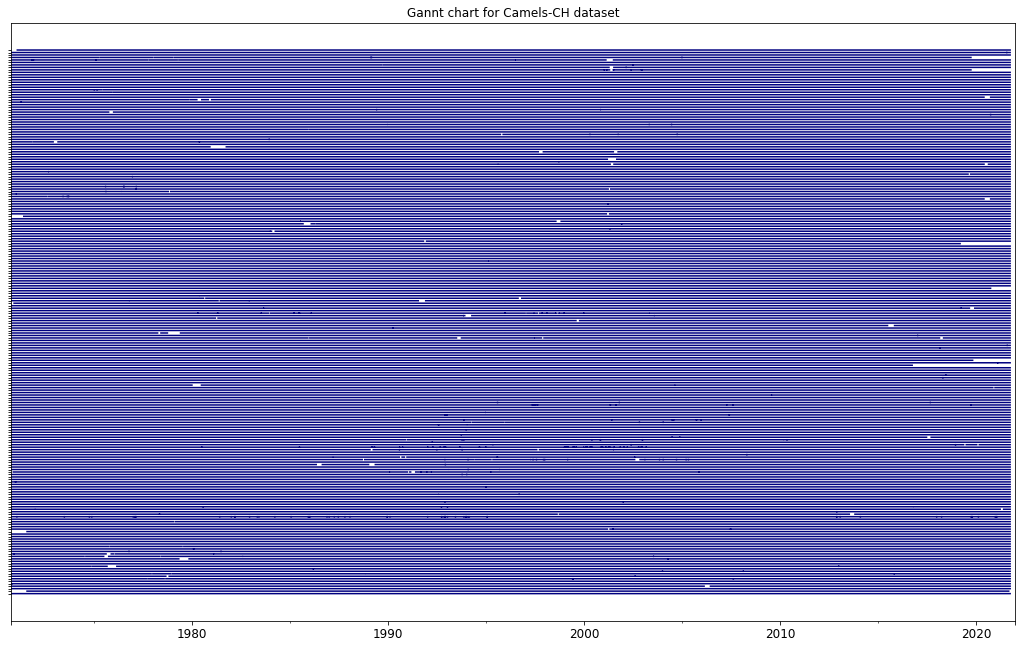

In [145]:
figplot, axesplot = geospatialfunctions.plotganntchart(timeseriesfinal_gantt = timeseriesfinal.loc["1970":"2021",:], 
                                                       
                                                       figsize_chart = (18, 11), showcodes = False,
                                                       color_chart = "navy", fontsize_chart = 12,facecolor_chart = "white", 
                                                       title_chart = "Gannt chart for Camels-CH dataset")

In [153]:
timeseriesfinal.loc["1970":"2021-09",:]

11001  21024  39027  22001  22006    23004   23006  24004  24005  \
1970-10-01  11.310    NaN  0.223  1.110  0.127   46.300  15.850  0.220  0.268   
1970-10-02  11.540    NaN  0.214  1.090  0.118  106.000  19.760  0.249  0.257   
1970-10-03  11.540    NaN  0.227  1.070  0.116   40.500   7.009  0.215  0.280   
1970-10-04  13.200    NaN  0.226  1.050  0.116   50.600  13.090  0.215  0.336   
1970-10-05  14.530    NaN  0.247  1.120  0.130  155.000  34.480  0.316  0.353   
...            ...    ...    ...    ...    ...      ...     ...    ...    ...   
2021-09-26   8.056    NaN  0.332  1.213  0.108    1.919   1.089  0.207  0.132   
2021-09-27  26.920    NaN  0.331  1.522  0.324   10.550  10.170  0.290  0.417   
2021-09-28  25.510    NaN  0.400  1.779  0.277   19.580  18.750  0.282  0.285   
2021-09-29  15.050    NaN  0.425  1.954  0.258   12.540   5.971  0.263  0.253   
2021-09-30  13.170    NaN  0.380  1.796  0.197    9.095  14.580  0.249  0.214   

            25006  ...  81002   83003  84008   84014  84016   84020   85003  \
1970-10-01  0.597  ...  58.85  33.180  5.205  40.380  3.285   6.867  41.990   
1970-10-02  2.040  ...  51.34  13.320  3.912  24.390  2.153   5.044  10.690   
1970-10-03  0.803  ...  33.56   5.971  1.454   8.114  0.989   2.232   6.606   
1970-10-04  1.960  ...  65.95  14.460  2.605  16.640  1.982   6.610  71.920   
1970-10-05  6.850  ...  40.28  11.410  5.127  28.490  2.537   5.239  25.180   
...           ...  ...    ...     ...    ...     ...    ...     ...     ...   
2021-09-26  0.093  ...  23.68     NaN  0.941   1.856  0.581   1.959     NaN   
2021-09-27  0.134  ...  51.82     NaN  1.679  19.080  1.493   5.110     NaN   
2021-09-28  0.346  ...  16.72     NaN  0.577   6.057  0.570   1.279     NaN   
2021-09-29  0.465  ...  15.71     NaN  0.736   3.821  0.699   2.744     NaN   
2021-09-30  0.571  ...  57.50     NaN  2.803  17.950  2.153  14.640     NaN   

             9002   9005   10002  
1970-10-01   6.525  0.827    NaN  
1970-10-02   8.493  2.200    NaN  
1970-10-03   8.493  1.345    NaN  
1970-10-04  12.250  1.812    NaN  
1970-10-05  10.980  1.260    NaN  
...            ...    ...    ...  
2021-09-26   5.834  0.535  1.138  
2021-09-27  39.780  6.017  2.118  
2021-09-28  17.830  1.501  2.204  
2021-09-29  10.360  0.900  1.563  
2021-09-30   8.764  0.876  1.433  

[18628 rows x 220 columns]

In [154]:
coords = network_streams[["gauge_lon", "gauge_lat"]]


# Our columns should be from the same type as our indexes: 
timeseriesfinal.columns = timeseriesfinal.columns.map(int)
summarygapsstations = geospatialfunctions.summarygaps(timeseriesfinal, coords)

summarygapsstations["area"] = network_streams.area

summarygapsstations

CoordX  CoordY  NumGaps  PercentageGaps     area
Code                                                   
10002   -1.83   57.53    488.0        2.569368   325.72
11001   -2.19   57.22    365.0        1.921761  1269.14
12001   -2.60   57.05    365.0        1.921761  1380.06
14001   -2.95   56.33    365.0        1.921761   308.74
15013   -3.51   56.42    449.0        2.364029   173.28
...       ...     ...      ...             ...      ...
84016   -4.02   55.93    365.0        1.921761    35.34
84020   -4.15   55.96    589.0        3.101143    51.92
85003   -4.72   56.34   1193.0        6.281262    79.92
9002    -2.49   57.54    365.0        1.921761   961.45
9005    -3.03   57.35    368.0        1.937556    68.08

[220 rows x 5 columns]

In [157]:
# Finally we can save our dataset:
timeseriesfinal.loc["1970":"2021-09",:].to_csv(r'GB\timeseries\timeseries_GB2.csv')